In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# this list contatins the years where we want to gather the data
list_of_years = ['1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

In [ ]:
def retrive_data_normal_scrapping():
    for year in list_of_years:
        # URL to scrape
        url = "http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/data/DPD" + year + ".txt"
        

        # url = "http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/additional/tilt_angle/tilt" + year + ".txt"

        # Send a GET request to the URL
        response = requests.get(url)

        # Check if the request was successful
        # Check if the request was successful
    if response.status_code == 200:
        # Get the content of the response
        content = response.text

        # Split the content into lines
        lines = content.splitlines()

        # dictionary to store the values: Keys-> Group number = values->dates that they appear
        group_dates = {}

        # Process each line
        for line in lines:
            # Split the line into columns based on whitespace
            columns = line.split()

            if line.startswith('g'):
                columns = line.split()

            # delete the irrelevant data from the list like time(in hours minutes and second)
            for idx,value in enumerate(columns):
                if idx == 4:
                    del columns[idx]
                    del columns[idx]
                    del columns[idx]

            print(" ".join(columns))
            print()  # Print a newline for better readability
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")
        return

In [44]:
def retrieve_and_process_data(year):
    
    url = f"http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/data/DPD{year}.txt"
    
    response = requests.get(url)

    if response.status_code == 200:
        content = response.text
        lines = content.splitlines()

        group_dates = {}

        for line in lines:
            if line.startswith('g'):
                columns = line.split()
                
                # Extract the group number (it's in the 7th position after removing whitespaces)
                group_number = columns[7]
                
                try:
                    int_conversion_of_group_number = int(group_number)
                except ValueError:
                    continue

                # Construct the date from the year, month, and day in the line
                date_str = f"{columns[1]}-{columns[2]}-{columns[3]}"
                date_obj = datetime.strptime(date_str, '%Y-%m-%d')

                # If the group number is not in the dictionary, add it with an empty list
                if group_number not in group_dates:
                    group_dates[group_number] = []

                # Append the date to the list for this group number
                group_dates[group_number].append(date_obj)
                
        last_two_months_groups = {group: dates for group, dates in group_dates.items() if any(d.month >= 11 for d in dates)}
        
        # Load data from the next year to check for overlaps
        next_year = int(year) + 1
        nextt_year = str(next_year)
        
        url_next_year = f"http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/data/DPD{nextt_year}.txt"
        response_next_year = requests.get(url_next_year)
        
        if response_next_year.status_code == 200:
            content_next_year = response_next_year.text
            lines_next_year = content_next_year.splitlines()

            for line in lines_next_year:
                if line.startswith('g'):
                    columns = line.split()
                    group_number = columns[7]
                    
                    try:
                        int_conversion_of_group_number = int(group_number)
                    except ValueError:
                        continue

                    date_str = f"{columns[1]}-{columns[2]}-{columns[3]}"
                    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
                    
                    # Only consider dates in January and February of the next year
                    if date_obj.month <= 2 and group_number in last_two_months_groups:
                        group_dates[group_number].append(date_obj)
                        
        return group_dates
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")
        return 0

def calculate_group_durations(group_dates):
    group_durations = {}
    
    for group, dates in group_dates.items():
        if dates:
            # Find the duration between the first and last date
            min_date = min(dates)
            max_date = max(dates)
            duration = (max_date - min_date).days + 1  # Including both start and end dates
            
            group_durations[group] = duration

    return group_durations

def find_avg_days_between_all_sunspots(year):
    all_group_dates = {}
    # list with all the sunspot groups and the date they appear
    year_group_dates = retrieve_and_process_data(year)
    if year_group_dates == 0:
        print('exiting because retrive_and_process data returned an error')
        return 0
    all_group_dates.update(year_group_dates)
    
    # Calculate the durations for each group
    group_durations = calculate_group_durations(all_group_dates)
    
    total_days = 0
    total_spots = 0
    for group, days in list(group_durations.items()):
        total_days += int(days)
        total_spots += 1
    all_group_dates = {}
    return total_days/total_spots

In [45]:

all_group_dates = {}

# Retrieve and process data for each year
year_group_dates = retrieve_and_process_data('1974')
all_group_dates.update(year_group_dates)

# Calculate the durations for each group
group_durations = calculate_group_durations(all_group_dates)

# Convert to DataFrame
df = pd.DataFrame(list(group_durations.items()), columns=['Group Number', 'Duration (Days)'])


In [46]:
list_of_average_sunspot_lifespan_per_year = []
for year in list_of_years:
    life_span_per_year = find_avg_days_between_all_sunspots(year)
    list_of_average_sunspot_lifespan_per_year.append(life_span_per_year)
    print("for the year {} the average life span for a sunspot group was: {}".format(year,life_span_per_year))

for the year 1974 the average life span for a sunspot group was: 6.9209039548022595
for the year 1975 the average life span for a sunspot group was: 6.153846153846154
for the year 1976 the average life span for a sunspot group was: 7.166666666666667
for the year 1977 the average life span for a sunspot group was: 6.158469945355192
for the year 1978 the average life span for a sunspot group was: 7.283261802575107
for the year 1979 the average life span for a sunspot group was: 7.794378698224852
for the year 1980 the average life span for a sunspot group was: 8.348047538200339
for the year 1981 the average life span for a sunspot group was: 7.824
for the year 1982 the average life span for a sunspot group was: 8.109649122807017
for the year 1983 the average life span for a sunspot group was: 8.0
for the year 1984 the average life span for a sunspot group was: 6.819148936170213
for the year 1985 the average life span for a sunspot group was: 6.682352941176471
for the year 1986 the average

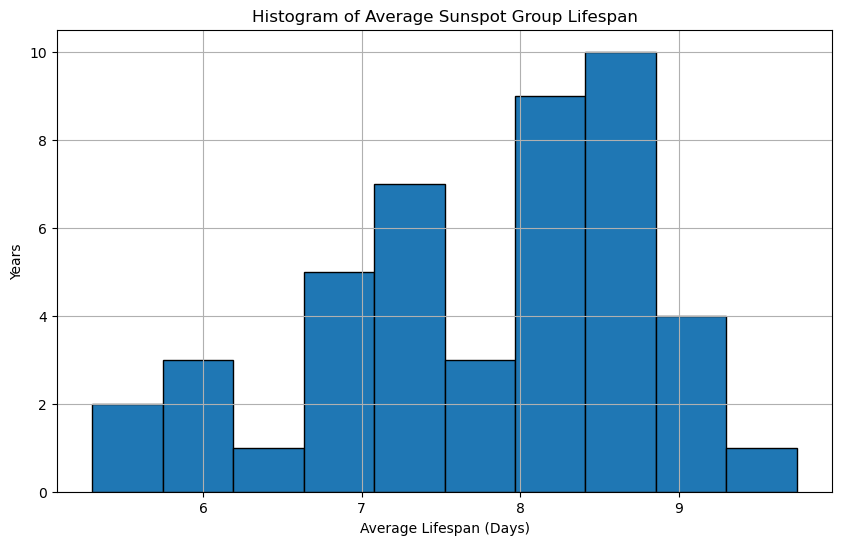

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(list_of_average_sunspot_lifespan_per_year, bins=10, edgecolor='black')
plt.title('Histogram of Average Sunspot Group Lifespan')
plt.xlabel('Average Lifespan (Days)')
plt.ylabel('Years')
plt.grid(True)
plt.show()

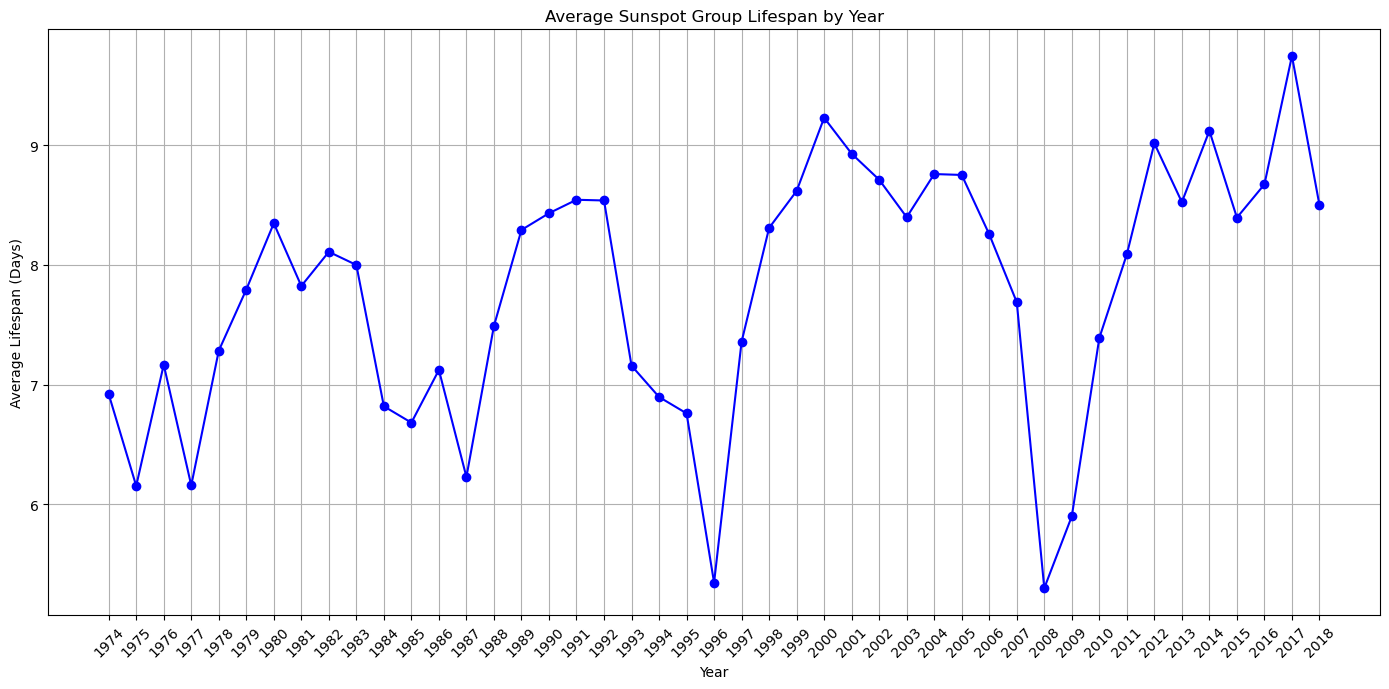

In [48]:
plt.figure(figsize=(14, 7))
plt.plot(list_of_years, list_of_average_sunspot_lifespan_per_year, marker='o', linestyle='-', color='b')
plt.title('Average Sunspot Group Lifespan by Year')
plt.xlabel('Year')
plt.ylabel('Average Lifespan (Days)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()